## Software Price

### Objectives:
The software company recently launched a test to evaluate whether a pricing test running on the site has been successful, and they want to understand the following: 

1. Should the company sell its software for $39 or $59?

2. The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are the main findings looking at the data?

3. The VP of Product feels that the test has been running for too long and she should have been able to get statistically significant results in a shorter time. After how many days would the test have been stopped? Please, explain why.

### Summary of Findings and Recommendations:

1. There is no statistically significant difference in conversion probability between the regular and sale prices, with the caveat that the conversion rate is low overall (~2%). The recommendation is to first improve the conversion rate before upping the price.

2. The highest number of visits came from Windows users (86000), but they have one of the lowest conversion rates (1.7%). This may be due to user experience. The suggestion will be redevelop website to optimize for Windows system to increase conversion rate.

3. Android has low conversion rate for mobiles (1.5%). The company should consider revamping mobile website for android.

4. Ads at Bing and Yahoo yield low conversion rate (Bing: 1.3%; Yahoo: 1.4%) and traffic. The recommendation would be pulling to redirect resources to search engine optimization. 

5. Big cities like NYC, Chicago, and Indianapolis have high traffic but below median conversion rate. Would recommend targetted marketting at those locations.

6. Power analysis using the old price as a control indicated that a minimum of 4366 visitors per group for a significance level of p < 0.01, so the test could have stopped after day 6.

#### Steps:
1. Import Data
2. Clean data
3. Initial EDA
4. A/B Testing: Did revenue increase after price increase to $59?
5. User segmentation: learn user behavior to help increase conversion rate
6. Effect size/power analysis: when should the A/B testing be stopped?

## 1. Import Data

In [1]:
import pandas as pd
import sklearn.metrics as metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl 
mpl.style.use('default')
%matplotlib inline
import seaborn as sns; #sns.set()

# import graphviz
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from datetime import datetime
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [2]:
all_data0 = pd.read_csv('test_results.csv')
all_data1 = pd.read_csv('user_table.csv')

all_data = pd.merge(all_data0,all_data1,how='inner',on='user_id')

In [3]:
print(all_data.shape)
all_data.head()

(275616, 13)


,Unnamed: 0,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39.0,0,Buffalo,USA,42.89,-78.86
1,1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39.0,0,Lakeville,USA,44.68,-93.24
2,2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39.0,0,Parma,USA,41.38,-81.73
3,3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59.0,0,Fayetteville,USA,35.07,-78.90
4,4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39.0,0,Fishers,USA,39.95,-86.02


## 2. Clean Data

In [4]:
# remove duplicates
all_data.drop_duplicates()

# ID number isn't necessary
all_data = all_data.drop(columns = ['Unnamed: 0'], axis = 1)
# all_data['Unnamed:0'].drop()

In [268]:
all_data.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39.0,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39.0,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39.0,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59.0,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39.0,0,Fishers,USA,39.95,-86.02


In [270]:
# check data type

all_data.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 275616 entries, 0 to 275615
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           275616 non-null  int64  
 1   timestamp         275322 non-null  object 
 2   source            275344 non-null  object 
 3   device            275616 non-null  object 
 4   operative_system  257839 non-null  object 
 5   test              275616 non-null  int64  
 6   price             275616 non-null  float64
 7   converted         275616 non-null  int64  
 8   city              275616 non-null  object 
 9   country           275616 non-null  object 
 10  lat               275616 non-null  float64
 11  long              275616 non-null  float64
dtypes: float64(3), int64(3), object(6)
memory usage: 27.3+ MB


In [5]:
# remove entries with null values
data_ints = all_data[all_data['operative_system'].notnull()].copy()
data_ints2 = data_ints[data_ints['timestamp'].notnull()].copy()
data_ints3 = data_ints2[data_ints2['source'].notnull()].copy()
print(data_ints3.shape)
data_ints3.info(verbose=True,null_counts=True)

(257298, 12)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 257298 entries, 0 to 275615
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           257298 non-null  int64  
 1   timestamp         257298 non-null  object 
 2   source            257298 non-null  object 
 3   device            257298 non-null  object 
 4   operative_system  257298 non-null  object 
 5   test              257298 non-null  int64  
 6   price             257298 non-null  float64
 7   converted         257298 non-null  int64  
 8   city              257298 non-null  object 
 9   country           257298 non-null  object 
 10  lat               257298 non-null  float64
 11  long              257298 non-null  float64
dtypes: float64(3), int64(3), object(6)
memory usage: 25.5+ MB


In [6]:
# define df as data frame with cleaned data
df = data_ints3.copy()
colnames = df.columns
print(data_ints3.columns)

Index(['user_id', 'timestamp', 'source', 'device', 'operative_system', 'test',
       'price', 'converted', 'city', 'country', 'lat', 'long'],
      dtype='object')


In [7]:
# clean up typos and convert timestamp to date time

df['operative_system'] = df['operative_system'].replace({'anroid':'android','i0S':'iOS','wnddows':'windows'})
df['timestamp'] = df['timestamp'].str.replace('60','00').str.replace('2815','2015')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['source'] = df['source'].str.replace('-','_')
df

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39.0,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo_google,mobile,android,0,39.0,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads_bing,mobile,android,0,39.0,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59.0,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39.0,0,Fishers,USA,39.95,-86.02
...,...,...,...,...,...,...,...,...,...,...,...,...
275611,388438,2015-05-20 11:34:44,seo_google,web,windows,1,59.0,0,Joliet,USA,41.53,-88.12
275612,687787,2015-03-16 23:31:55,direct_traffic,web,windows,0,39.0,0,Bell Gardens,USA,33.97,-118.15
275613,618863,2015-04-11 01:35:19,ads_google,web,mac,0,39.0,0,West Seneca,USA,42.84,-78.75
275614,154636,2015-05-14 05:46:42,friend_referral,mobile,android,0,39.0,0,Walnut Creek,USA,37.90,-122.04


## 3. Initial EDA

In [18]:
df.describe()

,user_id,test,price,converted,lat,long
count,257298.000000,257298.000000,2.572980e+05,257298.000000,257298.000000,257298.000000
mean,499102.377387,0.358903,6.398213e+06,0.018694,37.107098,-93.986260
std,288453.882316,0.479680,6.766017e+07,0.135443,5.210752,18.056965
min,3.000000,0.000000,3.900000e+01,0.000000,19.700000,-157.800000
25%,249553.000000,0.000000,3.900000e+01,0.000000,33.660000,-112.200000
50%,498554.500000,0.000000,3.900000e+01,0.000000,37.720000,-88.930000
75%,748557.000000,1.000000,5.900000e+01,0.000000,40.700000,-79.040000
max,999999.000000,1.000000,9.998843e+08,1.000000,61.180000,30.310000


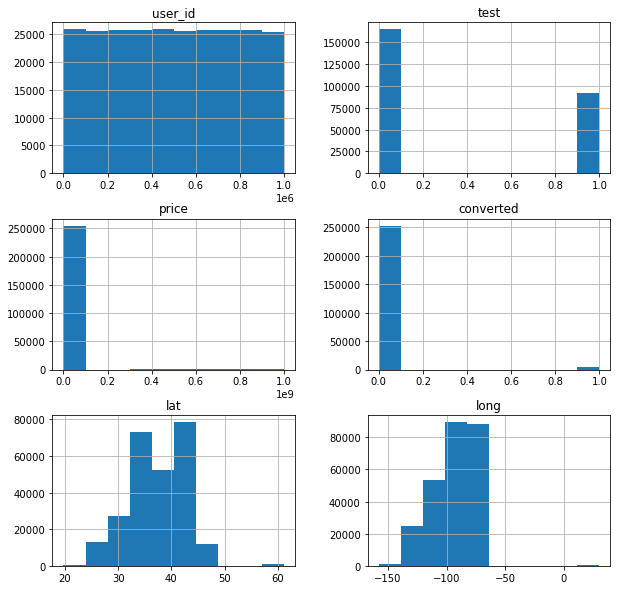

In [263]:
df.hist(figsize=(10,10));

Initial graphing of the variables (separated by conversion)

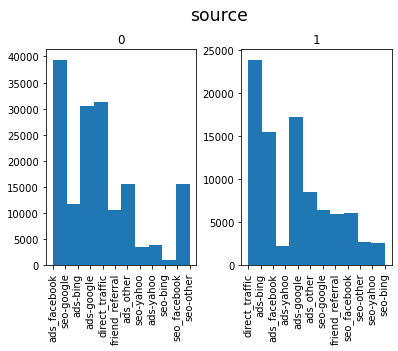

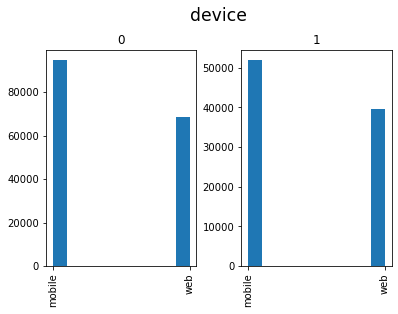

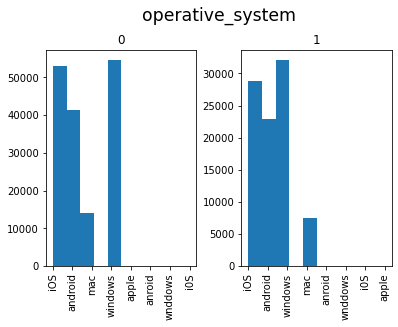

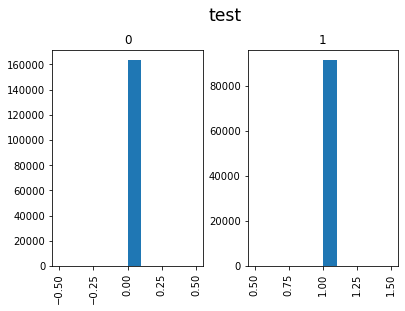

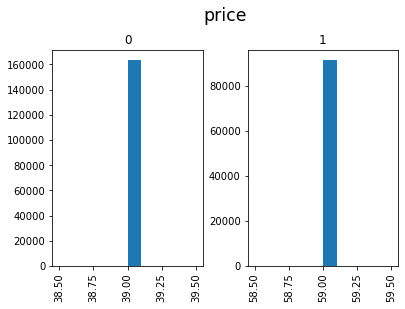

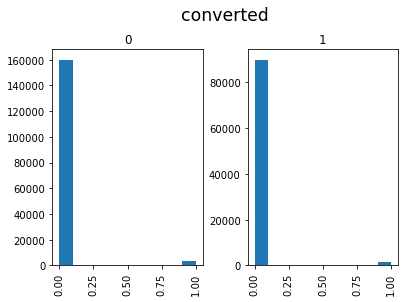

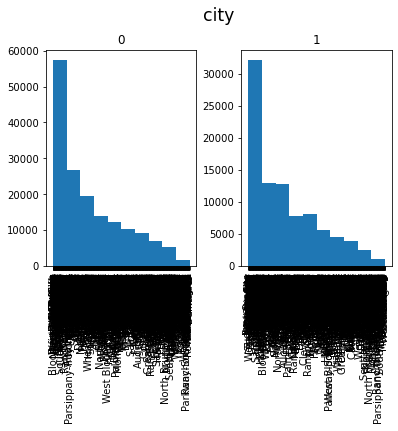

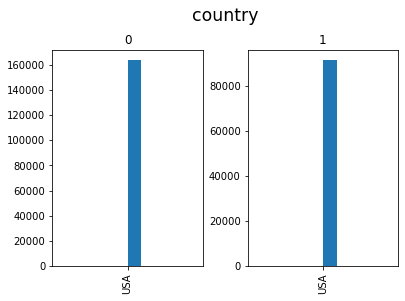

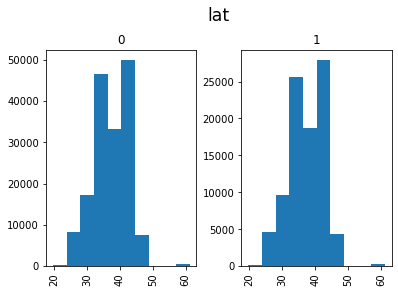

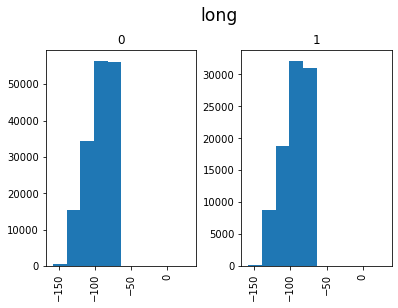

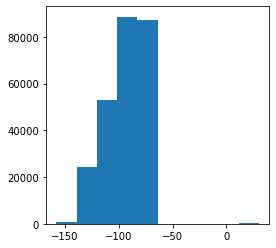

In [27]:
for i in colnames[2:]:
    df[i].hist(by=df['test'])
    plt.suptitle(i, x=0.5, y=1.05, ha='center', fontsize='xx-large')


Price may not correspond to test state, so use test state as criteria to parse existing vs. new prices.

First, check the mismatched price rows to make sure we're not greatly changing the conversion rate.

In [23]:
print(df[(df['test'] == 1)&(df['price'] != 59)].shape)
# print(df[(df['test'] == 1)].shape)
print(df[(df['test'] == 0)&(df['price'] != 39)].shape)



(1036, 12)
(1728, 12)


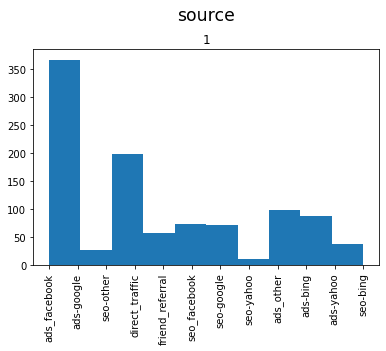

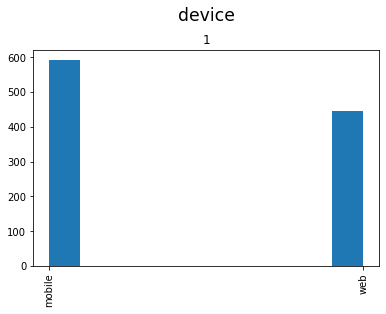

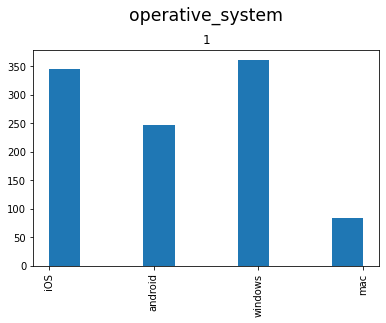

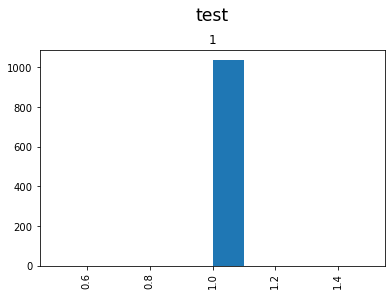

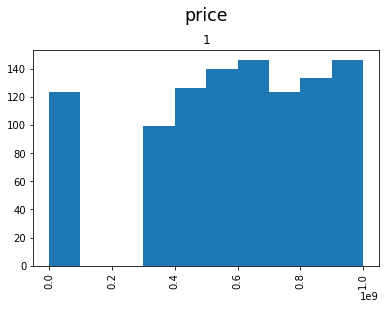

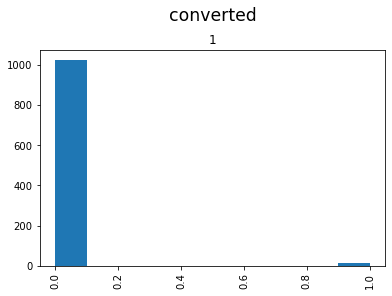

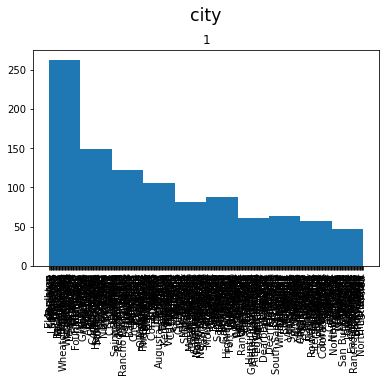

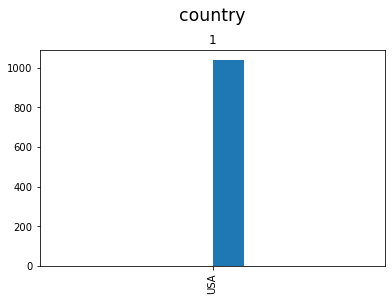

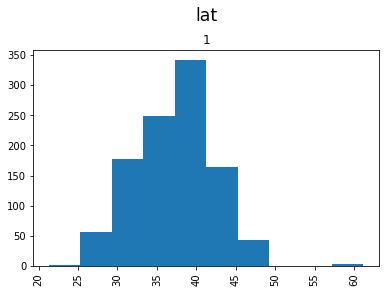

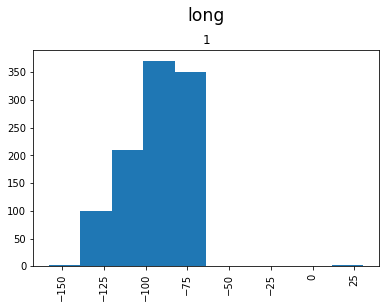

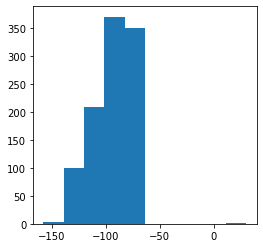

In [276]:
df_drop = df[(df['test'] == 1)&(df['price'] != 59)]

for i in colnames[2:]:
    df_drop[i].hist(by=df_drop['test'])
    plt.suptitle(i, x=0.5, y=1.05, ha='center', fontsize='xx-large')

fig, ax = plt.subplots(figsize = (4,4))  
plt.hist(df_drop[i]);

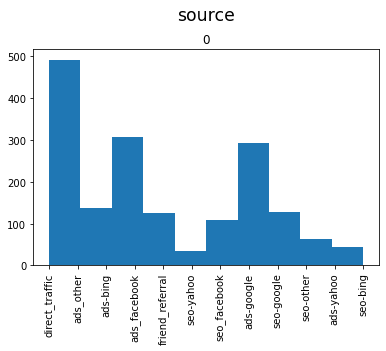

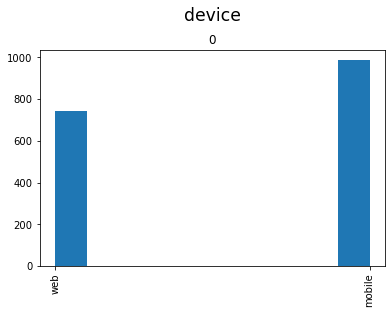

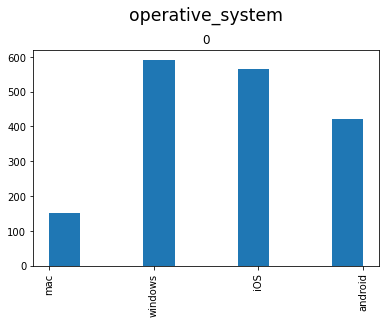

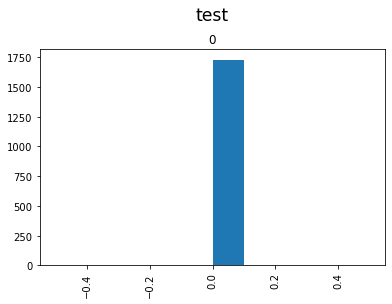

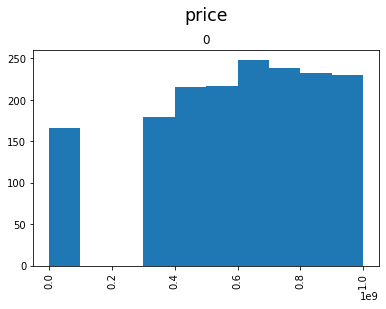

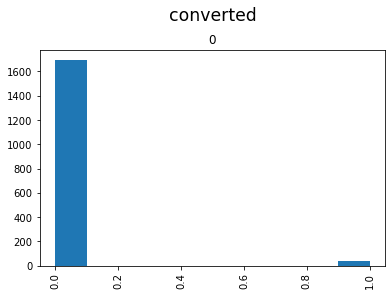

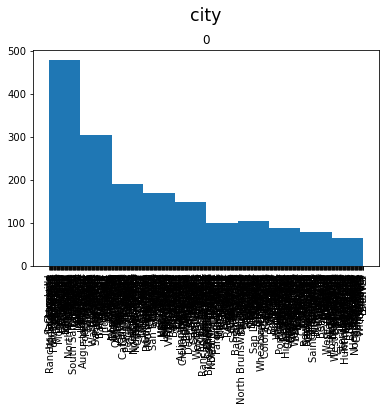

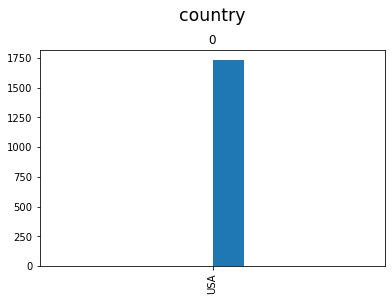

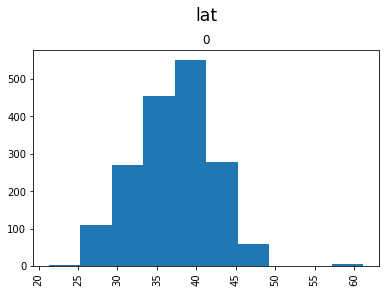

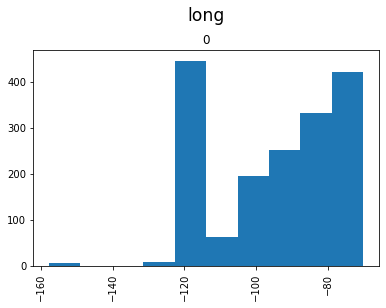

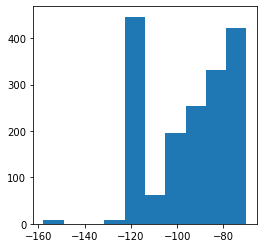

In [277]:
df_drop = df[(df['test'] == 0)&(df['price'] != 39)]

for i in colnames[2:]:
    df_drop[i].hist(by=df_drop['test'])
    plt.suptitle(i, x=0.5, y=1.05, ha='center', fontsize='xx-large')

fig, ax = plt.subplots(figsize = (4,4))  
plt.hist(df_drop[i]);

In [8]:
# drop rows with mismatched price
df.drop(df[(df['test'] == 1)&(df['price'] != 59)].index, inplace = True)
df.drop(df[(df['test'] == 0)&(df['price'] != 39)].index, inplace = True)

## 4. Did revenue go up after price increased to $59?

First, get a sense of fraction of test population, overall conversion rate and conversion rate between the old and new price.

In [296]:
df['test'].value_counts(normalize = True)

0    0.64127
1    0.35873
Name: test, dtype: float64

In [259]:
df['converted'].value_counts(normalize = True)

0    0.981306
1    0.018694
Name: converted, dtype: float64

Note: low overall conversion rate (~2%).

In [258]:
# divide people by test group
test = df.groupby('test')

test['converted'].value_counts(normalize = True)#normalize = True

test  converted
0     0            0.979813
      1            0.020187
1     0            0.983956
      1            0.016044
Name: converted, dtype: float64

There is virtually no difference in conversion rate between the old and new prices. 

We further verify whether revenue increases after increasing the price for some of the population.
We define revenue being amount of money earned per visit, or probability of conversion * price.

In [297]:
p_old = (df[(df['test']==0)&(df['converted']==1)].shape[0] / df[(df['test']==0)].shape[0]) * 39
p_new = (df[(df['test']==1)&(df['converted']==1)].shape[0] / df[(df['test']==1)].shape[0]) * 59

print('The revenue for old and new prices are $ %.2g and $ %.2g per visit, which is a %i percent increase.' % (p_old, p_new, (p_new-p_old)/p_old*100))

The revenue for old and new prices are $ 0.79 and $ 0.95 per visit, which is a 20 percent increase.


Using z-test (because sample size is sufficiently large) to verify the statistical significance of the conversion rate difference between the two price populations, where the null hypothesis (H0) is that there is no difference in conversion rate between the old price population and the new price population. 

In [257]:
import math
import scipy.stats as sp
confidence_level = 0.05 

prob_pooled = df[(df['converted']==1)].shape[0] / df.shape[0]
se_pooled = math.sqrt(prob_pooled * (1 - prob_pooled) * (1 / df[(df['test']==0)].shape[0] + 1 / df[(df['test']==1)].shape[0]))

z_score = sp.norm.ppf(1 - confidence_level / 2)
margin_of_error = se_pooled * z_score
dhat = (df[(df['test']==1)&(df['converted']==1)].shape[0] / df[(df['test']==1)].shape[0]) - \
       (df[(df['test']==0)&(df['converted']==1)].shape[0] / df[(df['test']==0)].shape[0])

lower_bound = dhat - margin_of_error
upper_bound = dhat + margin_of_error

print('Reject null hypothesis (There is no difference between two distributions)? ' + str(-practical_significance > upper_bound))

Reject null hypothesis (There is no difference between two distributions)? False


Take-home: There is no statistically significant difference in conversion probability between the regular and sale prices, so the revenue is technically higher for the higher price. However, the caveat is that the conversion rate is low overall. Recommend improving conversion rate before upping the price.

### EDA Part 2: Holistic view of user behavior to increase conversion rate

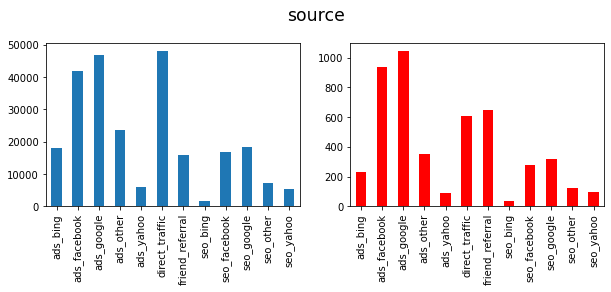

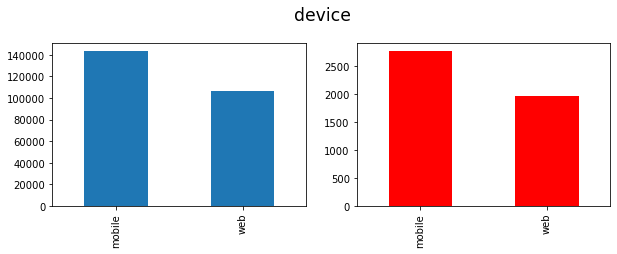

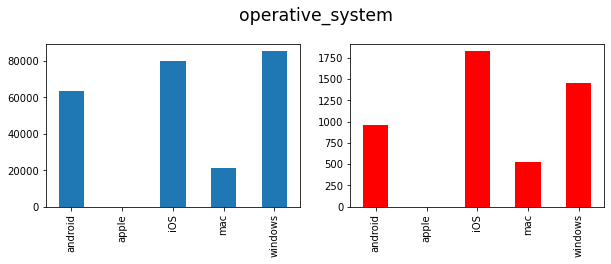

In [312]:
# compare user behavior of users who converted vs. not
for i in colnames[[2,3,4]]:
    fig, ax = plt.subplots(1,2,figsize = (10,3))  
    df.loc[df['converted']==0,i].value_counts().reindex(sorted(df[i].unique())).plot(kind="bar",ax = ax[0]);

    df.loc[df['converted']==1,i].value_counts().reindex(sorted(df[i].unique())).plot(kind="bar",color='red',ax = ax[1]);
    plt.suptitle(i, x=0.5, y=1.05, ha='center', fontsize='xx-large')

#### Check traffic sources

In [19]:
df['source'].unique()
# df['company_market'].nunique()

array(['ads_facebook', 'seo_google', 'ads_bing', 'direct_traffic',
       'ads_google', 'friend_referral', 'ads_other', 'ads_yahoo',
       'seo_yahoo', 'seo_facebook', 'seo_bing', 'seo_other'], dtype=object)

#### Check overall traffic distributed across the sources

In [30]:

df['source'].groupby(df['source'].str.split('_').map(lambda x:x[0])).count()/df['source'].shape[0]

source
ads       0.545966
direct    0.191043
friend    0.065469
seo       0.197522
Name: source, dtype: float64

Ads brings in more traffic than search engines and direct site visit. Friend referral makes up the least fraction of traffic.

In [43]:
df['source_type'] = df['source'].str.split('_').map(lambda x:x[0])
sources = df.groupby(['source_type'])

sources['source'].value_counts(normalize= True)#sum()/sources['converted'].count()

source_type  source         
ads          ads_google         0.343448
             ads_facebook       0.307872
             ads_other          0.173005
             ads_bing           0.131787
             ads_yahoo          0.043888
direct       direct_traffic     1.000000
friend       friend_referral    1.000000
seo          seo_google         0.368745
             seo_facebook       0.338134
             seo_other          0.148520
             seo_yahoo          0.109834
             seo_bing           0.034768
Name: source, dtype: float64

Further breaking down the traffic sources:
- most ads and search engine traffics come from google and facebook, while bing and yahoo ads and searches yield the least traffic.

In [77]:
# calculate conversion rate for each group
df[['source_type','converted']].groupby('source_type').sum()/df[['source_type','converted']].groupby('source_type').count()

,converted
source_type,
ads,0.019105
direct,0.012483
friend,0.038706
seo,0.016966


Note: Friend referral has the highest conversion rate by far (3.9%). Ads yields slightly higher conversion rate than search engines. 

In [78]:
df[['source','converted']].groupby('source').sum()/df[['source','converted']].groupby('source').count()

,converted
source,
ads_bing,0.012504
ads_facebook,0.021924
ads_google,0.021874
ads_other,0.014683
ads_yahoo,0.014920
direct_traffic,0.012483
friend_referral,0.038706
seo_bing,0.022311
seo_facebook,0.016412


Note:
- highest conversion rates come from friend referral (3.9%); 
- next tier of conversion rates are bing search, facebook ads, google ads (~2.2%);
- lowest conversion rates come from direct traffic (1.2%), bing ads (1.3%), and yahoo ads (1.4%). Redirect resources for Bing and Yahoo ads to revamp website to optimize conversion rate.

#### Check traffic distributed across devices

In [79]:
df[['operative_system','converted']].groupby('operative_system').count()

,converted
operative_system,
android,64504
apple,23
iOS,81901
mac,21526
windows,86580


In [80]:
df[['operative_system','converted']].groupby('operative_system').sum()/df[['operative_system','converted']].groupby('operative_system').count()

,converted
operative_system,
android,0.014852
apple,0.000000
iOS,0.022271
mac,0.024203
windows,0.016828


Note:
- Although windows has the highest number of visits, it has one of the lowest conversion rates. This may be due to user experience. The suggestion will be redevelop website for windows to increase conversion rate.
- Android has low conversion rate for mobiles. Consider revamping mobile website for android.

In [81]:
df.loc[df['operative_system'] == 'android',['source','converted']].groupby('source').count()

,converted
source,
ads_bing,4603
ads_facebook,10644
ads_google,11978
ads_other,6068
ads_yahoo,1506
direct_traffic,12693
friend_referral,4185
seo_bing,430
seo_facebook,4315


Checking traffic sources from android systems, where most traffic came from direct traffic, facebook ad, and google ads. 

In [82]:
df.loc[df['operative_system'] == 'android',['source','converted']].groupby('source').sum()/\
df.loc[df['operative_system'] == 'android',['source','converted']].groupby('source').count()

# df[df['source']=='friend_referral']

,converted
source,
ads_bing,0.010428
ads_facebook,0.018414
ads_google,0.017449
ads_other,0.010712
ads_yahoo,0.009960
direct_traffic,0.008115
friend_referral,0.037515
seo_bing,0.020930
seo_facebook,0.011819


In [83]:
df.loc[df['operative_system'] == 'iOS',['source','converted']].groupby('source').sum()/\
df.loc[df['operative_system'] == 'iOS',['source','converted']].groupby('source').count()

,converted
source,
ads_bing,0.014735
ads_facebook,0.025619
ads_google,0.025639
ads_other,0.017871
ads_yahoo,0.017233
direct_traffic,0.015567
friend_referral,0.043855
seo_bing,0.016639
seo_facebook,0.020015


#### Check traffic distributed across cities

In [75]:
# first, just rank cities by total number of conversion
market_money = df[['city','converted']].groupby('city', sort=False).sum().sort_values(
    by = ['converted','city'],ascending=[False,True]).reset_index()
market_money[:10]
# market_money.sort_values(by = ['raised_amount_total_usd','company_market'],ascending=[False,True]) #'raised_amount_total_usd')

,city,converted
0,New York,420
1,Houston,113
2,Chicago,93
3,San Antonio,79
4,Los Angeles,77
5,Austin,61
6,San Jose,55
7,Philadelphia,46
8,Indianapolis,43
9,Jacksonville,42


Find cities with the highest traffic (count from each city, regardless of converted or not) and their conversion rates:

In [56]:
market_money = df[['city','converted']].groupby('city', sort=False).sum()
market_money2 = df[['city','converted']].groupby('city', sort=False).count()

market_money2['converted rate'] = market_money['converted']/market_money2['converted']
market_money2['converted sum'] = market_money['converted']
market_money2 = market_money2.rename(columns = {'converted':'total visit'})

with pd.option_context('mode.use_inf_as_null', True):
#     market_money2 = market_money2.sort_values(by = ['converted rate'],ascending=[False],na_position='last').reset_index()
    market_money2 = market_money2.sort_values(by = ['total visit'],ascending=[False],na_position='last').reset_index()

market_money2[:20]

,city,total visit,converted rate,converted sum
0,New York,23806,0.017643,420
1,Chicago,6676,0.013930,93
2,Houston,6152,0.018368,113
3,San Antonio,4303,0.018359,79
4,Los Angeles,3819,0.020162,77
5,San Jose,3124,0.017606,55
6,Indianapolis,3008,0.014295,43
7,Jacksonville,2701,0.015550,42
8,Philadelphia,2315,0.019870,46
9,Las Vegas,2224,0.017986,40


Find median conversion rate across cities (which we can use as a benchmark)

In [71]:
market_summary = market_money2.describe()
print(market_summary.loc['50%','converted rate'])
market_summary

0.01769926905673512


,total visit,converted rate,converted sum
count,922.000000,922.000000,922.000000
mean,276.067245,0.019599,5.162690
std,901.152370,0.020479,16.012943
min,1.000000,0.000000,0.000000
25%,72.000000,0.009901,1.000000
50%,150.500000,0.017699,3.000000
75%,256.000000,0.025189,5.000000
max,23806.000000,0.333333,420.000000


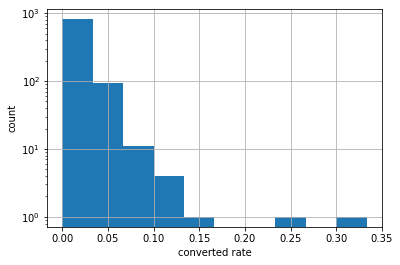

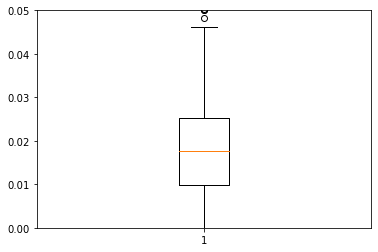

In [72]:
# Plot distribution in conversion rates
market_money2['converted rate'].hist()
plt.yscale('log')
# plt.xscale('log')
plt.xlabel('converted rate')
plt.ylabel('count')

fig, ax = plt.subplots();
plt.boxplot(market_money2['converted rate']);
ax.set_ylim(0,.05);

Conversion rate is widely distributed across the cities.

Look at cities with highest traffic and see whether their conversion rate is above or below the median rate.

In [74]:
market_money2[market_money2['converted rate']<(market_summary.loc['50%','converted rate'])][:10]

,city,total visit,converted rate,converted sum
0,New York,23806,0.017643,420
1,Chicago,6676,0.013930,93
5,San Jose,3124,0.017606,55
6,Indianapolis,3008,0.014295,43
7,Jacksonville,2701,0.015550,42
15,Virginia Beach,1588,0.015113,24
21,Fort Worth,1320,0.017424,23
22,Raleigh,1206,0.016584,20
23,Buffalo,1186,0.016863,20
25,Springfield,1138,0.014060,16


Note: 
- 15 out of 25 cities with highest traffic has below median conversion rate.
- Addition marketing may help to increase conversion rate in these cities (which clearly has much interest).

What about potential new markets (e.g. cities with lowest amount of traffic)?

In [88]:
with pd.option_context('mode.use_inf_as_null', True):
    market_money2 = market_money2.sort_values(by = ['total visit'],ascending=[True])#.reset_index(),na_position='last'

market_money2[:10]

,city,total visit,converted rate,converted sum
921,East Lake,1,0.000000,0
917,Ocala,1,0.000000,0
920,Cerritos,1,0.000000,0
919,New Milford,1,0.000000,0
918,Costa Mesa,1,0.000000,0
915,Tustin,2,0.000000,0
916,Little Rock,2,0.000000,0
914,Albuquerque,2,0.000000,0
911,Baltimore,3,0.000000,0
913,North Atlanta,3,0.333333,1


Note:
- East Lake (Seattle), Ocala, Cerritos and Costa Mesa (LA), New Milford have the low traffic.
- These may new markets to target for new sales.

What about potential new markets with some existing traffic (e.g. number of visit >=100)?

In [93]:
with pd.option_context('mode.use_inf_as_null', True):
    market_money3 = market_money2[market_money2['total visit']>=100].sort_values(by = ['converted rate'],ascending=[False],na_position='last')#.reset_index()

market_money3[:10]


,city,total visit,converted rate,converted sum
547,Springdale,118,0.059322,7
542,Dearborn,119,0.058824,7
539,Gastonia,119,0.050420,6
604,Parker,100,0.050000,5
476,Mission Viejo,145,0.048276,7
338,Moreno Valley,195,0.046154,9
510,Franklin,132,0.045455,6
501,Bossier City,135,0.044444,6
552,Woodbury,117,0.042735,5
532,Salinas,123,0.040650,5


Note:
- Springdale, Dearborn, and Gastonia have some existing traffic and decent conversion rates (~5-6%), so company may consider promote more in those regions to increase sales.

## 3. How long should the A/B testing last?

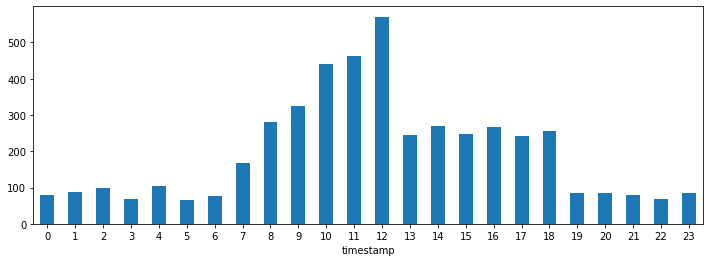

In [109]:
fig, axs = plt.subplots(figsize=(12, 4))

df.groupby(df["timestamp"].dt.hour)["converted"].sum().plot(kind='bar', rot=0,ax=axs);

Bulk conversion rate across the testing time period.

<AxesSubplot:xlabel='timestamp'>

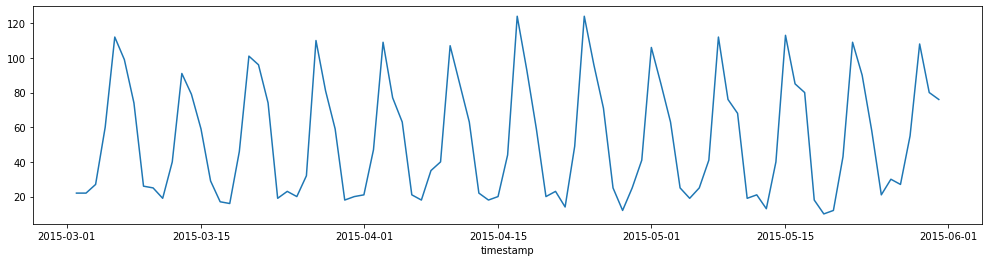

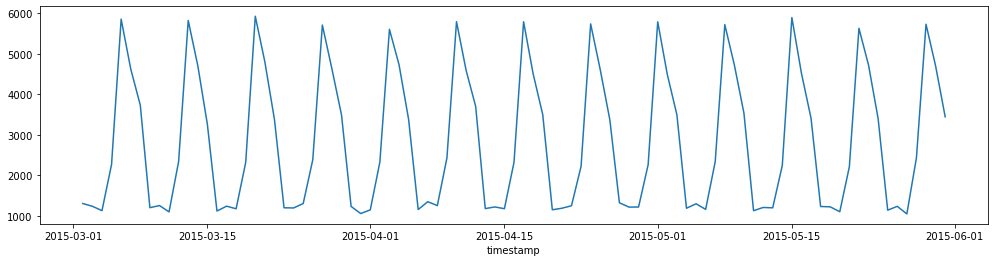

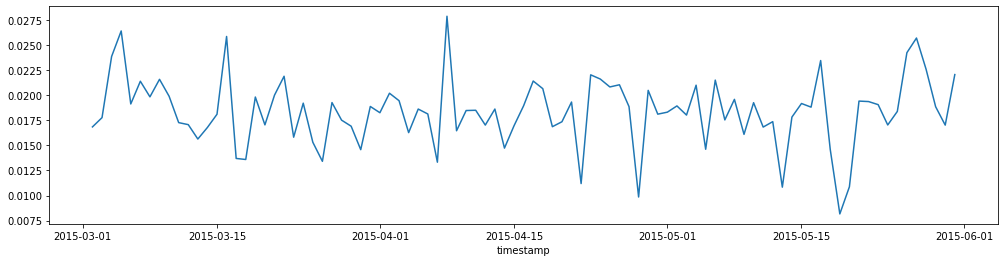

In [199]:
fig, axs = plt.subplots(figsize=(17, 4))

df.groupby(df["timestamp"].dt.date)["converted"].sum().plot(rot=0,ax=axs)

fig, axs = plt.subplots(figsize=(17, 4))

df.groupby(df["timestamp"].dt.date)["converted"].count().plot(rot=0,ax=axs)

fig, axs = plt.subplots(figsize=(17, 4))

df.groupby(df["timestamp"].dt.date)["converted"].mean().plot(rot=0,ax=axs)

Cumulative number of visits across the testing time period.

<AxesSubplot:xlabel='timestamp'>

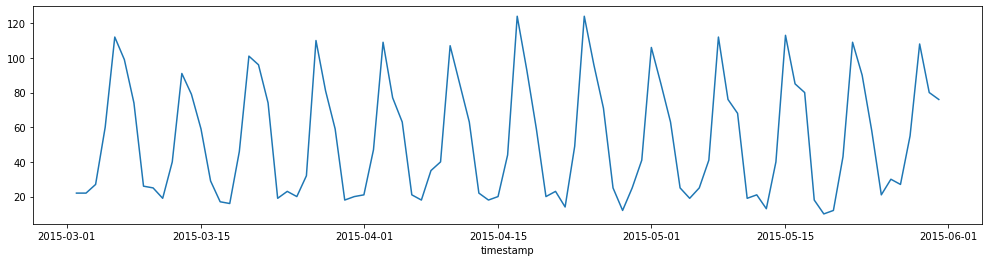

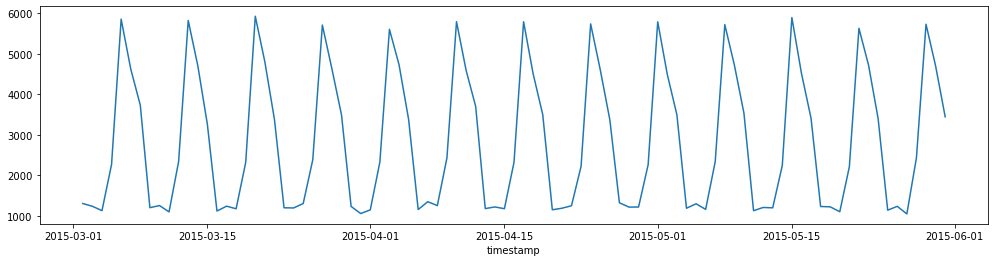

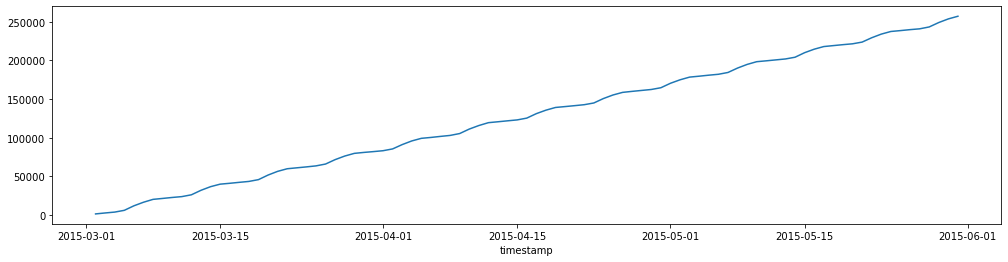

In [201]:
fig, axs = plt.subplots(figsize=(17, 4))

df.groupby(df["timestamp"].dt.date)["converted"].sum().plot(rot=0,ax=axs)

fig, axs = plt.subplots(figsize=(17, 4))

df.groupby(df["timestamp"].dt.date)["converted"].count().plot(rot=0,ax=axs)

fig, axs = plt.subplots(figsize=(17, 4))

df.groupby(df["timestamp"].dt.date)["converted"].count().cumsum().plot(rot=0,ax=axs)

Cumulative number of visits for the old price and new price populations across the testing time period.

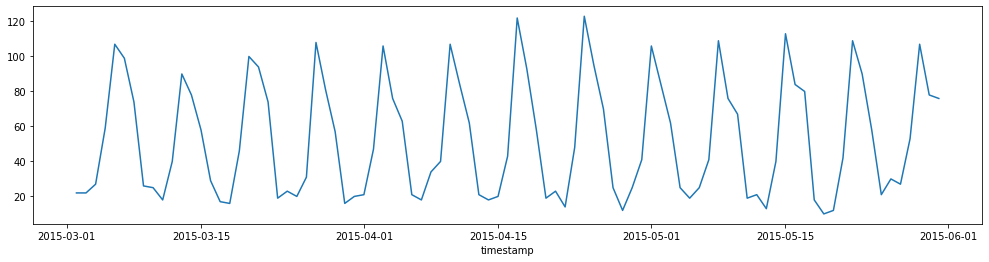

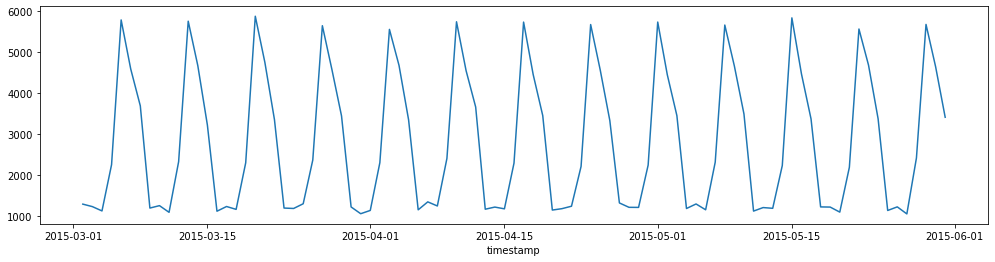

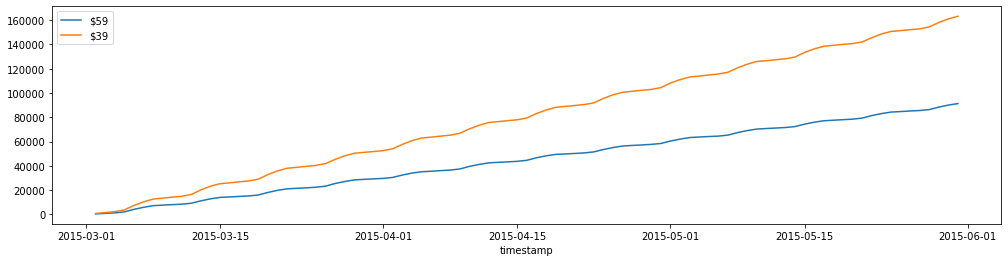

In [94]:
fig, axs = plt.subplots(figsize=(17, 4))

df.groupby(df["timestamp"].dt.date)["converted"].sum().plot(rot=0,ax=axs)

fig, axs = plt.subplots(figsize=(17, 4))

df.groupby(df["timestamp"].dt.date)["converted"].count().plot(rot=0,ax=axs)

fig, axs = plt.subplots(figsize=(17, 4))

df[df['test']==1].groupby(df["timestamp"].dt.date)["converted"].count().cumsum().plot(rot=0,ax=axs,label='\$59')
df[df['test']==0].groupby(df["timestamp"].dt.date)["converted"].count().cumsum().plot(rot=0,ax=axs,label='\$39')
plt.legend();

Plot revenue normalized by visits for old vs new prices over the testing time period.

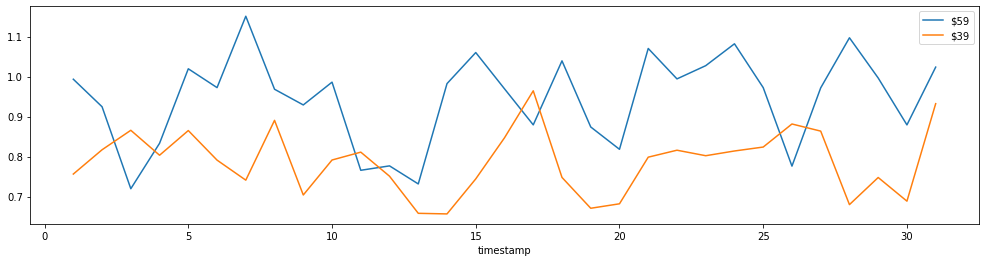

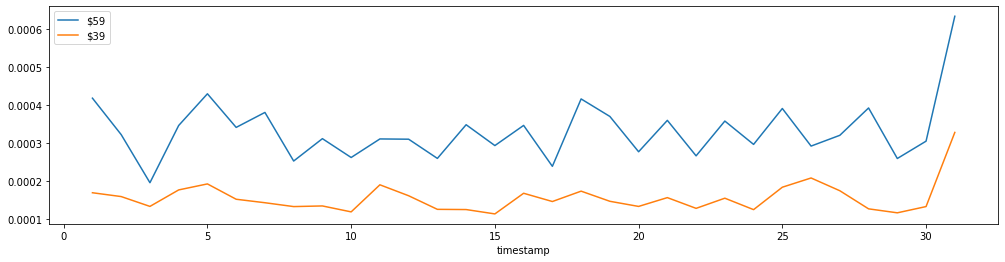

In [107]:
fig, axs = plt.subplots(figsize=(17, 4))

df[df['test']==1].groupby(df["timestamp"].dt.day)["converted"].mean().mul(59).plot(rot=0,ax=axs,label='\$59')
df[df['test']==0].groupby(df["timestamp"].dt.day)["converted"].mean().mul(39).plot(rot=0,ax=axs,label='\$39')
plt.legend();

fig, axs = plt.subplots(figsize=(17, 4))

x = df[df['test']==1].groupby(df["timestamp"].dt.day)["converted"].mean().mul(59)/df[df['test']==1].groupby(df["timestamp"].dt.day)["converted"].count()
x.plot(rot=0,ax=axs,label='\$59');
x2 = df[df['test']==0].groupby(df["timestamp"].dt.day)["converted"].mean().mul(39)/df[df['test']==0].groupby(df["timestamp"].dt.day)["converted"].count()
x2.plot(rot=0,ax=axs,label='\$39');

# df[df['test']==1].groupby(df["timestamp"].dt.day)["converted"].count().mul(59).plot(rot=0,ax=axs,label='\$59')
# df[df['test']==0].groupby(df["timestamp"].dt.day)["converted"].count().mul(39).plot(rot=0,ax=axs,label='\$39')
plt.legend();

#### Power Analysis

In [238]:
import statsmodels.api as sm
import statsmodels.stats.power as smso
baseline_rate = df[(df['test']==0)&(df['converted']==1)].shape[0]/df[(df['test']==0)].shape[0]
practical_significance = 0.01 
confidence_level = 0.05 
sensitivity = 0.85 

effect_size = sm.stats.proportion_effectsize(baseline_rate, 
              baseline_rate + practical_significance)
sample_size = smso.NormalIndPower().solve_power(effect_size = effect_size, 
             power = sensitivity, alpha = confidence_level)
print('Min. sample size is ' + str(int(sample_size)))

Min. sample size is 4366


In [240]:
sum_customer_0 = df[df['test']==0].groupby(df["timestamp"].dt.date)["converted"].count().cumsum().tolist()
sum_customer_1 = df[df['test']==1].groupby(df["timestamp"].dt.date)["converted"].count().cumsum().tolist()

res_0 = next(x for x, val in enumerate(sum_customer_0) if val > int(sample_size))
res_1 = next(x for x, val in enumerate(sum_customer_1) if val > int(sample_size))
print('The minimum day to get enough samples is ' + str(max([res_0,res_1])))

The minimum day to get enough samples is 5


## Summary and Recommendation

1. There is no statistically significant difference in conversion probability between the regular and sale prices, with the caveat that the conversion rate is low overall. Would recommend improving conversion rate before upping the price.

2. The highest number of visits came from Windows users, but they have one of the lowest conversion rates. This may be due to user experience. The suggestion will be redevelop website to optimize for Windows system to increase conversion rate.

3. Android has low conversion rate for mobiles. Consider revamping mobile website for android.

4. Seach engines bring in the highest amount of traffic and lower conversion rate than ads. Would recommend optimizing searches to boost conversion rate. Ads at Bing and Yahoo yield low conversion rate and traffic, so may consider pulling to redirect resources to search engine optimization. 

5. Big cities like NYC, Chicago, and Indianapolis have high traffic but low conversion rate. Would recommend targetted marketting at those locations.

6. Power analysis using the old price as a control indicated that a minimum of 4366 visitors per group for a significance level of p < 0.01, so the test could have stopped after day 6.